In [ ]:
import pandas 
import numpy as np 
import gc
import random
from collections import OrderedDict
from sklearn.preprocessing import * 
from keras.models import *
from keras.layers import *

In [ ]:
  
#!gzip -dv /content/processed.npy.gz
'''
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/duolingo/processed.rar /content/
%pip install patool
import patoolib
patoolib.extract_archive("processed.rar", outdir="/content")
'''
dataset = np.asarray(np.load('processed.npy')).astype(np.float)  

# DA CANCELLARE
dataset = dataset[0:int(len(dataset)/8)]

<ipython-input-8-cc01ac5d46c0>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dataset = np.asarray(np.load('processed.npy')).astype(np.float)


In [ ]:
# constants
MINIMUM_ROWS_PER_SEQUENCE = len(dataset[0])
TRAIN_TEST_SPLIT = 0.9

In [ ]:
 
np.random.shuffle(dataset)  

output = np.array(dataset[:,dataset.shape[1]-1, 0])
output = np.expand_dims(output, axis=1) 
  

In [ ]:
print(dataset[2,:,:])

[[-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.0000

In [ ]:
# creating the new dataset as:
# [previous_output, delta, session_seen]
for row in range(dataset.shape[0]):
    for seq in range(dataset.shape[1]-1, -1, -1):
        if seq == 0:
            dataset[row,seq,0] = -1
        else:
            dataset[row,seq,0] = dataset[row,seq-1,0] 
            if dataset[row,seq,0] == -1 and dataset[row,seq,1] != -1:
                dataset[row,seq,0] = 0
             

In [ ]:
print(output[2])

[0.]


In [ ]:


#normalization
 
normalized = []

index = 0
best = 0
for el in dataset:
  for seq in el:
    normalized.append(seq) 
    if (seq[1] / (3600*24)) > 60: 
        best = index
    index += 1 
normalized = np.array(normalized, dtype=np.float) 
# NOTA: con ReLU fai in modo di non avere ouput negativi
scaler = StandardScaler(with_mean = False)

scaler.fit(normalized[:,1:2])
normalized[:,1:2] /= 3600*24
#normalized[:,1:2] = scaler.transform(normalized[:,1:2]) 

#scaler.fit(normalized[:,4:5])
#normalized[:,4:5] = scaler.transform(normalized[:,4:5]) 

# fixing wrong normalization
for i in range(len(normalized)): 
    if normalized[i][0] == -1:
        for k in range(1, len(normalized[i])):
            normalized[i][k] = -1
 

dataset = np.array(np.array_split(normalized, len(normalized)/MINIMUM_ROWS_PER_SEQUENCE), dtype=np.float) 

# leave only p_recall, delta, session_seen
dataset = dataset[:,:,[0,1,4]]

<ipython-input-12-f04f55616cf1>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  normalized = np.array(normalized, dtype=np.float)
<ipython-input-12-f04f55616cf1>:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dataset = np.array(np.array_split(normalized, len(normalized)/MINIMUM_ROWS_PER_SEQUENCE), dtype=np.float)


In [ ]:
# RNN input calc
rnn_input_test = dataset[int(len(dataset)*TRAIN_TEST_SPLIT):]
rnn_input = dataset[:int(len(dataset)*TRAIN_TEST_SPLIT)] 
output_test = output[int(len(output)*TRAIN_TEST_SPLIT):]
output = output[:int(len(output)*TRAIN_TEST_SPLIT)]
 

# momentaneamente usiamo solo train
# quando useremo test, dobbiamo fare finta di averlo solo alla fine
# ossia non lo normalizziamo all'inizio ma solo dopo l'allenamento
# dropout?

In [ ]:
print(rnn_input[100])

[[-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+

In [ ]:

weights_calc = np.array([ 0 if i[-3][0] == -1 else 1 for i in rnn_input])
print(weights_calc[:1000])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [ ]:
temp = rnn_input

In [ ]:
rnn_input = temp

In [ ]:
for i in range(int(len(rnn_input)/20)):
    idx = random.randint(0, len(rnn_input)-1)
    if random.randint(1,1) == 1:
        delta = random.randint(1000, 10000)
        output[idx][0] = 0
        rnn_input[idx][-1][1] = delta 


In [ ]:
# creating a weighted loss 
m = dict()
for i in rnn_input:
    if i[-3][0] == -1:
        continue
    if int(i[-1][1]*2.0) not in m:
        m[int(i[-1][1]*2.0) ] = 0
    m[int(i[-1][1]*2.0)] += 1
 

total_1 = sum([(1 if i[0] == 1 else 0) for i in output])
total_0 = sum([(1 if i[0] == 0 else 0) for i in output])
total_others = len(output)-total_1-total_0

weights_calc = np.array([ 1000.0/(m[1]) if i[-3][0] == -1 else (i[-1][1]*1000.0/m[int(i[-1][1]*2.0)] if m[int(i[-1][1]*2.0)] > 500 else 1000.0/(m[1]))  for i in rnn_input])
# weights_calc = np.array([(1 if i[0] != 1 else 1) for i in output]) 

In [ ]:
m[7]

814

In [ ]:
output

array([[0. ],
       [0. ],
       [0.5],
       ...,
       [0.5],
       [0. ],
       [0. ]])

array([[-0.00097222],
       [-0.04383102],
       [-0.00108218],
       ...,
       [-0.00190394],
       [-0.00540509],
       [-0.39125579]])

In [ ]:
# we do have 6 elements, each one with: p_recall, delta, history_seen, history_correct, session_seen, session_correct
# we keep 5 of those for the LSTM RNN
# we use another network with the 6th element and 5 features (all except p_recall)
# we connect the networks and try to predict the last p_recall

tf.keras.backend.clear_session() 

rnn_layer_input = Input(shape=rnn_input[0].shape)
rnn_layer_0 = Masking(mask_value=-1.0)(rnn_layer_input)   
rnn_layer_1 = GRU(30, dropout=.15)(rnn_layer_0)
dense_layer_000 = Dense(30, activation='relu') (rnn_layer_1)   
dense_layer_00 = Dropout(0.15) (dense_layer_000)   
dense_layer_0 = Dense(1, activation='sigmoid', name="cases") (dense_layer_00)  

model = Model([rnn_layer_input], [dense_layer_0])
metrics=["AUC", "MAE"]
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss="mae", metrics=metrics)
 
# beta regression 
#print(rnn_input[:6])
model.fit([rnn_input], output,sample_weight=weights_calc, epochs=50, batch_size=1000, validation_data=([rnn_input_test], output_test))

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
120/120 [==============================] - 30s 204ms/step - loss: 0.0538 - auc: 0.7388 - MAE: 0.3640 - val_loss: 0.3593 - val_auc: 0.7817 - val_MAE: 0.3593
Epoch 2/50
120/120 [==============================] - 20s 168ms/step - loss: 0.0501 - auc: 0.7922 - MAE: 0.3351 - val_loss: 0.3472 - val_auc: 0.8247 - val_MAE: 0.3472
Epoch 3/50
120/120 [==============================] - 20s 169ms/step - loss: 0.0489 - auc: 0.8116 - MAE: 0.3280 - val_loss: 0.3418 - val_auc: 0.8338 - val_MAE: 0.3418
Epoch 4/50
120/120 [==============================] - 21s 172ms/step - loss: 0.0479 - auc: 0.8219 - MAE: 0.3224 - val_loss: 0.3377 - val_auc: 0.8467 - val_MAE: 0.3377
Epoch 5/50
120/120 [==============================] - 20s 167ms/step - loss: 0.0470 - auc: 0.8323 - MAE: 0.3156 - val_loss: 0.3266 - val_auc: 0.8170 - val_MAE: 0.3266
Epoch 6/50
120/120 [==============================] - 20s 169ms/step - loss: 0.0463 - auc: 0.8332 - MAE: 0.3061 - val_loss: 0.3474 - val_auc: 0.8250 - val_MAE: 0.347

KeyboardInterrupt: ignored

In [ ]:
print(rnn_input[7])
print(output[7])

[[-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+

In [ ]:
model.evaluate([rnn_input_test[:,0,:], rnn_input_test[:,1,:],rnn_input_test[:,2,:],rnn_input_test[:,3,:],rnn_input_test[:,4,:],rnn_input_test[:,5,:], dense_input_test], output_test)

In [ ]:
rnn_input_test[3][-1][1]

3.249386574074074

In [ ]:
maxx = 0
for i in rnn_input:
    if i[-1][1] > maxx:
        maxx = i[-1][1]
print(maxx)

11.016168981481481


[[[-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
  [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
  [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
  [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
  [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
  [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
  [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
  [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
  [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  9.00000000e+00]
  [ 1.00000000e+00  5.05026620e+00  1.00000000e+00]
  [ 0.00000000e+00  1.66666667e-03  1.00000000e+00]
  [ 1.00000000e+00  1.04166667e-03  1.00000000e+00]
  [ 1.00000000e+00  7.11805556e-03  1.00000000e+00]
  [ 0.00000000e+00  7.52314815e-04  1.00000000e+00]
  [ 1.00000000e+00  1.66666667e-03  1.00000000e+00]
  [ 1.00000000e+00  8.33333333e-04  1.00000000e+00]
  [ 1.00000000e+00  1.29347222e+00  1.00000000e+00]
  [ 0.00000000e+00  2.54629630e-03  1.00000000e+00]
  [ 1.000000

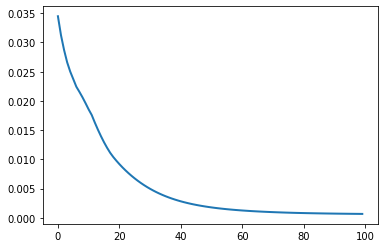

In [ ]:

  ind = np.random.randint(0, len(rnn_input_test))
  example_rnn = np.array(np.expand_dims(rnn_input_test[ind], 0))
  print(example_rnn) 
  print(ind)
 
  if True:
    x = []
    y = []
    for i in range(100):
      j = (i)
      x.append(j)
      
      example_rnn[0][-6][0] = 1
      example_rnn[0][-6][1] = 0
      example_rnn[0][-5][0] = 1
      example_rnn[0][-5][1] = 0
      example_rnn[0][-4][0] = 1
      example_rnn[0][-4][1] = 0.01
      example_rnn[0][-3][0] = 1
      example_rnn[0][-3][1] = 0
      example_rnn[0][-2][0] = 1
      example_rnn[0][-2][1] = 0.01
      
      example_rnn[0][-1][1] = j 
      #print(example_rnn)
      #print(model.predict([example_rnn],verbose = 0))
      y.append(model.predict([example_rnn],verbose = 0)[0][0])
!pip install matplotlib

import matplotlib.pyplot as plt 

# make data
x = np.array(x)
y = np.array(y)

# plot
fig, ax = plt.subplots()

ax.plot(x, y, linewidth=2.0)
 

plt.show()

